# Import

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define

In [202]:
def array_sign(array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(array>0) - 1.*(array<0)

class VariableArray():
    def __init__(self, size, cs_initial=0.01):
        self.v = np.random.normal(0., 1., size) # array values
        self.td = np.zeros(self.v.shape) # total derivative, used to descent
        self.ltd = None # last total derivative
        self.m = np.zeros(self.v.shape) # moving array
        self.cs = cs_initial*np.ones(self.v.shape) # component-wise step
        self.work = np.ones(self.v.shape) # working components, defult to be fully connected
    
    def assign_values(self, values, cs_initial=0.01):
        self.v = values
        self.td = np.zeros(self.v.shape)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = cs_initial*np.ones(self.v.shape)
        self.work = np.ones(self.v.shape)
    
    def derivative_assign(self, values):
        if values.shape != self.td.shape:
            raise ValueError("values shape error")
        
        self.ltd = np.array(self.td)
        self.td = values
    
    def descent(self, step = 1., descent_method = "normal"):
        if descent_method == "normal":
            self.m = np.array(self.td)
            self.v -= step * self.m * self.work
        elif descent_method == "Rprop":
            self.m = array_sign(self.td)
            if type(self.ltd) != type(None):
                self.cs *= 0.7*(self.td*self.ltd>0) +0.5 # 1.2 for positive, 0.5 for negtive
            
            self.cs = self.cs * (self.cs < 1.) + 1.*(self.cs >= 1.)
            
            self.v -= self.cs * self.m * self.work

class Identity():
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.ones(x.shape, dtype = np.float64)

class Sigmoid():
    def trans(self, x):
        return 1. / (1. + np.exp(-x))
    
    def diff(self, x): 
        return 1. / (np.exp(x) + np.exp(-x) + 2.)

class Hypertan():
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        return 1. / np.square(np.cosh(x))

class Relu():
    def trans(self, x):
        return x*(x>0)
    
    def diff(self, x):
        return (x>0).astype(np.float64)

class LeakyRelu():
    def __init__(self, alpha = 0.):
        self.alpha = alpha
    
    def trans(self, x):
        return x*(x>0) + self.alpha*x*(x<0)
    
    def diff(self, x):
        return (x>0) + self.alpha*(x<0)

class SoftPlus():
    def trans(self, x):
        return np.log(1. + np.exp(x))
    
    def diff(self, x):
        return 1. / (1. + np.exp(-x))

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def trans(self, x):
        return self.ahpha*(x*(x>0) + self.beta*(np.exp(x) - 1)*(x<0))
    
    def diff(self, x):
        return self.ahpha*((x>0) + self.beta*np.exp(x)*(x<0))

class Layer():
    def __init__(self, neuron_n, activation_function):
        self.nn = neuron_n
        self.af = activation_function
        self.w = VariableArray((self.nn, 0)) # linear weights working before active function
        self.b = VariableArray((self.nn)) # bias working before active function
        self.x = np.zeros((0, self.nn))
        self.y = np.zeros((0, self.nn))
    
    def forward(self, _input):
        temp_dn = _input.shape[1] # _input datum n
        self.x = np.dot(self.w.v, _input) + self.b.v.repeat(temp_dn).reshape((self.nn, temp_dn))
        self.y = self.af.trans(self.x)
    
    def backward(self, _input, source):
        derivative = self.af.diff(self.x)*_input
        self.w.derivative_assign(np.dot(derivative, source.T))
        self.b.derivative_assign(np.sum(derivative, axis=1))
        derivative = np.dot(derivative.T, self.w.v)
        return derivative.T
    
    def descent(self, step = 1., descent_method = "normal"):
        self.w.descent(step, descent_method)
        self.b.descent(step, descent_method)

class DogikoLearn():
    def __init__(self, loss_function = "r2"):
        self.lf = loss_function # loss function type
        self.ly = [] # layers list
    
    def set_training_data(self, training_input, training_labels):
        self.tx = np.array(training_input) # training data input
        self.ty = np.array(training_labels) # training data lables(answers)
        if self.tx.shape[0] != self.ty.shape[0]:
            temp_min = min(self.tx.shape[0], self.ty.shape[0])
            self.tx = self.tx[:temp_min]
            self.ty = self.ty[:temp_min]
            print("training data #input != #output, took the minimun size automatically")
        
        self.xs = self.tx.shape[1] # size of each datum input
        self.ys = self.ty.shape[1] # size of each datum output
    
    def set_validating_data(self, validating_input, validating_labels):
        self.vx = np.array(validating_input) # validating data input
        self.vy = np.array(validating_labels) # validating data lables(answers)
        if self.vx.shape[1] != self.xs:
            raise ValueError("validating data input size should be equal to training data")
        
        if self.vy.shape[1] != self.ys:
            raise ValueError("validating data lables size should be equal to training data")
    
    def add_layer(self, new_layer):
        self.ly.append(new_layer)
    
    def build(self):
        self.ln = len(self.ly) # amount of layers
        self.ly[0].w.assign_values(np.random.normal(0., 1., (self.ly[0].nn, self.xs)))
        self.ly[0].b.assign_values(np.random.normal(0., 1., (self.ly[0].nn)))
        for l in range(1,self.ln):
            self.ly[l].w.assign_values(np.random.normal(0., 1., (self.ly[l].nn, self.ly[l-1].nn)))
            self.ly[l].b.assign_values(np.random.normal(0., 1., (self.ly[l].nn)))
        
        if self.ly[-1].nn != self.ys: # cheak output size
            raise ValueError("output layer must has the same size with datum lables(answer)")
    
    def prediction(self, data_input):
        self.px = np.array(data_input) # prediction data input of last time predic
        if self.px.shape[1] != self.xs:
            raise ValueError("datum size error")
        
        self.ly[0].forward(self.px.T)
        for l in range(1,self.ln):
            self.ly[l].forward(self.ly[l-1].y)
        
        self.py = self.ly[l].y.T # prediction result of last time predict
    
    def descent(self, step = 1., descent_method = "normal"):
        for l in range(self.ln):
            self.ly[l].descent(step, descent_method)
    
    def batch_fit(self, batch_input, batch_labels, step = 1., descent_method = "normal"):
        self.prediction(batch_input)
        if self.lf == "r2":
            temp_derivative = 2*(self.py - batch_labels).T/(batch_labels.shape[0]*batch_labels.var(axis=0).sum())
        
        for l in range(self.ln-1, 0, -1):
            temp_derivative = self.ly[l].backward(temp_derivative, self.ly[l-1].y)
        
        self.ly[0].backward(temp_derivative, batch_input.T)
        self.descent(step, descent_method)
    
    def validate(self):
        self.prediction(self.vx)
        if self.lf == "r2":
            return np.square(self.py - self.vy).mean()/self.vy.var(axis=0).mean()


# Example 1

Fit $y = \sin{x}$

In [76]:
X = (np.arange(81)/20) - 2
X = X.reshape((81,1))
Y = np.sin(2*X)

In [101]:
NN = DogikoLearn()
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(10,Selu()))
NN.add_layer(Layer(1,Identity()))
NN.build()
for i in range(100):
    NN.batch_fit(X,Y,step=0.02, descent_method="Rprop")

NN.validate()

0.092996741833478919

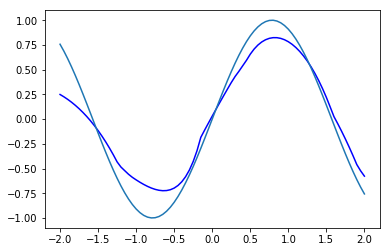

In [97]:
plt.plot(X.reshape((81)), NN.py.reshape((81)), "b", X.reshape((81)), Y.reshape((81)))
plt.show()

# Example 2

Net-shape classification

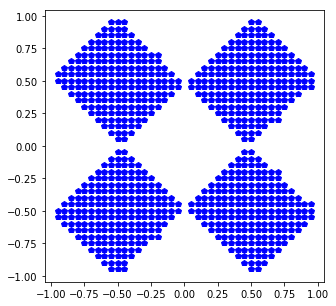

In [203]:
X = np.array([np.arange(41).repeat(41), np.arange(41*41) % 41]).astype(np.float64)
X -= 20.
X /= 20.
Y = (((X[0] + X[1] - 0.5) % 2.) > 1.) ^ (((X[0] - X[1] - 0.5) % 2.) > 1.)
Y = Y.reshape((Y.shape + (1,))).astype(np.float64)
X = X.T
plt.figure(figsize=(5,5))
plt.plot(X.T[0][Y.T[0] == 1], X.T[1][Y.T[0] == 1], "bp")
plt.show()

In [249]:
NN = DogikoLearn()
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(20,Relu()))
NN.add_layer(Layer(20,Relu()))
NN.add_layer(Layer(1,Sigmoid()))
NN.build()

for i in range(500):
    NN.batch_fit(X,Y,step=0.01, descent_method="Rprop")

NN.validate()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


0.073664586583533545

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp


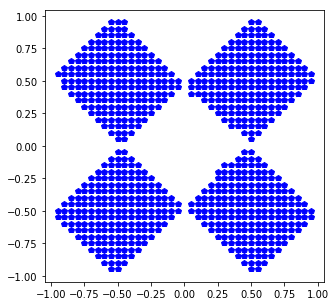

In [251]:
NN.prediction(X)
P = NN.py > 0.5

plt.figure(figsize=(5,5))
plt.plot(X.T[0][P.T[0]], X.T[1][P.T[0]], "bp")
plt.show()

In [266]:
np.exp(-1.*NN.ly[2].x)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([[  4.23269986e+38,   9.92921798e+33,   6.38741455e+29, ...,
          1.65341015e+07,   1.72656335e+08,   1.80295313e+09]])